# Text clustering: HDBSCAN is probably all you need

<a target="_blank" href="https://colab.research.google.com/github/daniel-furman/awesome-chatgpt-prompts-clustering/blob/main/notebooks/anthropic-hh-rlhf-clustering.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Sections

1. Setup
2. Data I/O
3. Embed text
4. Clustering
5. Exemplar sub-clustering
6. Knowledge graph theming
7. Write final df results to disk
8. Create a JSON knowledge graph viz

## Setup

In [1]:
# copying larger files to GDrive storage for this experiment

from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!git clone https://github.com/daniel-furman/awesome-chatgpt-prompts-clustering.git

Cloning into 'awesome-chatgpt-prompts-clustering'...
remote: Enumerating objects: 390, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 390 (delta 12), reused 15 (delta 6), pack-reused 369
Receiving objects: 100% (390/390), 4.32 MiB | 16.52 MiB/s, done.
Resolving deltas: 100% (224/224), done.


In [3]:
# for local run, see below commands for setting up a new venv

#!python -m venv .venv_clust_demo
#!source .venv_clust_demo/bin/activate
#!pip install --upgrade pip
#!pip list

In [4]:
import os

os.chdir("/content/awesome-chatgpt-prompts-clustering")
!ls

experiments  LICENSE  notebooks  README.md  requirements.txt


In [ ]:
!pip install -qUr requirements.txt

In [ ]:
os.chdir("../..")
!ls

In [7]:
#!pip list

In [8]:
import argparse
from tqdm.notebook import tqdm
import datetime
import os
import pickle
import numpy as np
from numpy import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import umap
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import torch
import hdbscan
from sklearn.metrics.pairwise import euclidean_distances
import openai
from UliPlot.XLSX import auto_adjust_xlsx_column_width

In [9]:
args = argparse.Namespace()
args.inference = False
args

Namespace(inference=False)

In [10]:
now = datetime.datetime.now()
# dd/mm/YY H:M:S
dt_string = now.strftime("%d_%m_%Y_%H_%M_%S")

# hardcode in an existing experiment datetime for inference runs

if args.inference:
    # dt_string identifiers from cached experiments:
    dt_string = "03_09_2023_22_34_08"

print("experiment's datetime identifier =", dt_string)

# create results folder if it doesn't exist
if not os.path.isdir(
    f"/content/drive/MyDrive/colab_files/text_clustering/experiments/{dt_string}"
):
    os.mkdir(
        f"/content/drive/MyDrive/colab_files/text_clustering/experiments/{dt_string}"
    )

experiment's datetime identifier = 03_09_2023_22_34_08


In [14]:
args.cache_folder = (
    f"/content/drive/MyDrive/colab_files/text_clustering/experiments/{dt_string}"
)
args

Namespace(inference=False, cache_folder='/content/drive/MyDrive/colab_files/text_clustering/experiments/03_09_2023_22_34_08')

## Data I/O

In [43]:
ds_hf = load_dataset("Gustavosta/Stable-Diffusion-Prompts")
ds = ds_hf["test"]

ds = ds.to_pandas()
ds["id"] = ds.index
ds = ds[["id", "Prompt"]]
ds

,id,Prompt
0,0,"young, curly haired, redhead Natalie Portman ..."
1,1,a mystical tribal goddess adorned with feather...
2,2,"molly millions, portrait of a beautiful cyberp..."
3,3,"cyborg sweating water, big drops of sweat, for..."
4,4,"Max Headroom in a Perfume advertisement, magic..."
...,...,...
8187,8187,"portrait of samuel jackson as gandalf, by alan..."
8188,8188,a photorealistic hyperrealistic render of an i...
8189,8189,"occult leader by artgerm, tooth wu, dan mumfor..."
8190,8190,"front shot of an alien cargo ship, intricate, ..."


## Embed Text

* See [pretrained models](https://www.sbert.net/docs/pretrained_models.html) for supporting information

In [ ]:
model = SentenceTransformer("all-mpnet-base-v2")

In [17]:
if not args.inference:
    embeddings = torch.zeros([len(ds), 768])
    for i in tqdm(range(len(ds))):
        emb = model.encode(ds.loc[i, "Prompt"], convert_to_tensor=True)
        embeddings[i, :] = emb
    embeddings

  0%|          | 0/8192 [00:00<?, ?it/s]

In [28]:
f_name = os.path.join(
    args.cache_folder, "stable_diffusion_prompts_embeddings_all_mpnet_base_v2.pt"
)
print(f_name, "\n")

if not args.inference:
    torch.save(embeddings, f_name)
loaded_embeddings = torch.load(f_name)
loaded_embeddings

/content/drive/MyDrive/colab_files/text_clustering/experiments/03_09_2023_22_34_08/stable_diffusion_prompts_embeddings_all_mpnet_base_v2.pt 



tensor([[ 0.0192,  0.0320,  0.0042,  ..., -0.0251,  0.0115,  0.0042],
        [ 0.0289,  0.0180, -0.0289,  ...,  0.0197, -0.0487, -0.0290],
        [-0.0102,  0.0610, -0.0228,  ...,  0.0140, -0.0346, -0.0328],
        ...,
        [ 0.0668,  0.0205, -0.0099,  ...,  0.0103, -0.0509, -0.0155],
        [ 0.0259, -0.0111,  0.0047,  ...,  0.0093, -0.0461, -0.0200],
        [ 0.0583,  0.0421, -0.0117,  ...,  0.0232, -0.0134, -0.0224]])

In [29]:
loaded_embeddings.shape

torch.Size([8192, 768])

In [30]:
if not args.inference:
    torch.equal(loaded_embeddings.cpu(), embeddings.cpu())

In [31]:
test_itr = random.randint(low=0, high=len(ds))
test_itr

594

In [32]:
# test embeddings worked
ds.loc[test_itr, "Prompt"]

'an architecture concept art of an eco skinny skyscraper, vegetal walls, parcs in the front, city in the background, blue sky, 4 k, high quality, artstation'

In [33]:
test_emb = model.encode(ds.loc[test_itr, "Prompt"], convert_to_tensor=True)
a = np.array(test_emb.cpu())
b = np.array(loaded_embeddings[test_itr, :].cpu())
np.allclose(a, b, rtol=1e-03)

True

In [34]:
test_emb.cpu()[1]

tensor(0.0331)

In [35]:
loaded_embeddings[test_itr, :].cpu()[1]

tensor(0.0331)

In [36]:
f_name_cp = os.path.join(
    args.cache_folder, "stable_diffusion_prompts_embeddings_all_mpnet_base_v2.pt"
)
f_name_cp

'/content/drive/MyDrive/colab_files/text_clustering/experiments/03_09_2023_22_34_08/stable_diffusion_prompts_embeddings_all_mpnet_base_v2.pt'

In [37]:
if not args.inference:
    os.system(f"cp {f_name} {f_name_cp}")

## Clustering

* See [how hdbscan works](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html) for supporting information

In [46]:
# second, perform clustering

# first, perform dimensionality reduction from 768 to 15
f_name = os.path.join(args.cache_folder, "reducer_umap_15.pkl")
print(f_name, "\n")

if not args.inference:
    reducer_15 = umap.UMAP(n_components=15)
    reducer_15.fit(loaded_embeddings)
    embeddings_umap_dim_15 = reducer_15.transform(loaded_embeddings)
    # Verify that the result of calling transform is
    # idenitical to accessing the embedding_ attribute
    assert np.all(embeddings_umap_dim_15 == reducer_15.embedding_)

    # cache fitted umap object
    pickle.dump(reducer_15, open(f_name, "wb"))

loaded_reducer_15 = pickle.load((open(f_name, "rb")))

embeddings_umap_dim_15 = loaded_reducer_15.transform(loaded_embeddings)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert np.all(embeddings_umap_dim_15 == loaded_reducer_15.embedding_)

print(embeddings_umap_dim_15.shape)

f_name = os.path.join(args.cache_folder, "clusterer_hdbscan.pkl")
print(f_name, "\n")

if not args.inference:
    clusterer = hdbscan.HDBSCAN(min_cluster_size=15, gen_min_span_tree=True)
    clusterer.fit(embeddings_umap_dim_15)
    pickle.dump(clusterer, open(f_name, "wb"))

loaded_clusterer = pickle.load((open(f_name, "rb")))

if not args.inference:
    print(
        pd.DataFrame.equals(
            pd.Series(clusterer.labels_).value_counts(),
            pd.Series(loaded_clusterer.labels_).value_counts(),
        )
    )
    print(
        pd.DataFrame.equals(
            pd.Series(clusterer.probabilities_).value_counts(),
            pd.Series(loaded_clusterer.probabilities_).value_counts(),
        )
    )

num_ouliers = pd.Series(loaded_clusterer.labels_).value_counts().loc[-1]

print(pd.Series(loaded_clusterer.labels_).value_counts())
print(f"\nCluster outliers : {num_ouliers}\n")

/content/drive/MyDrive/colab_files/text_clustering/experiments/03_09_2023_22_34_08/reducer_umap_15.pkl 

(8192, 15)
/content/drive/MyDrive/colab_files/text_clustering/experiments/03_09_2023_22_34_08/clusterer_hdbscan.pkl 

True
True
-1     4291
 58     335
 64     233
 51     212
 26     148
       ... 
 0       16
 11      16
 12      16
 3       16
 62      15
Name: count, Length: 78, dtype: int64

Cluster outliers : 4291



In [47]:
ds["cluster"] = loaded_clusterer.labels_
ds["cluster membership prob"] = loaded_clusterer.probabilities_
ds

,id,Prompt,cluster,cluster membership prob
0,0,"young, curly haired, redhead Natalie Portman ...",46,1.000000
1,1,a mystical tribal goddess adorned with feather...,51,0.954661
2,2,"molly millions, portrait of a beautiful cyberp...",58,0.790786
3,3,"cyborg sweating water, big drops of sweat, for...",58,1.000000
4,4,"Max Headroom in a Perfume advertisement, magic...",-1,0.000000
...,...,...,...,...
8187,8187,"portrait of samuel jackson as gandalf, by alan...",-1,0.000000
8188,8188,a photorealistic hyperrealistic render of an i...,-1,0.000000
8189,8189,"occult leader by artgerm, tooth wu, dan mumfor...",-1,0.000000
8190,8190,"front shot of an alien cargo ship, intricate, ...",60,0.895878


<Axes: ylabel='$\\lambda$ value'>

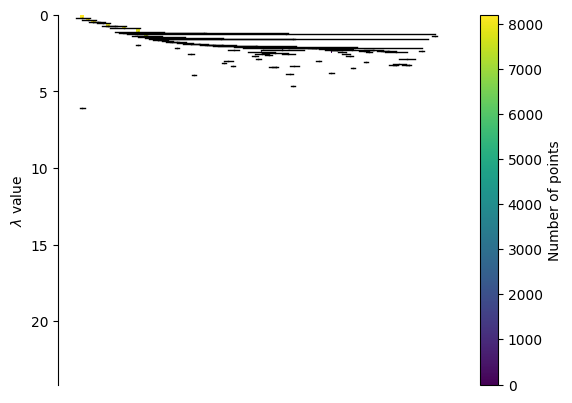

In [48]:
loaded_clusterer.condensed_tree_.plot()

<Axes: ylabel='$\\lambda$ value'>

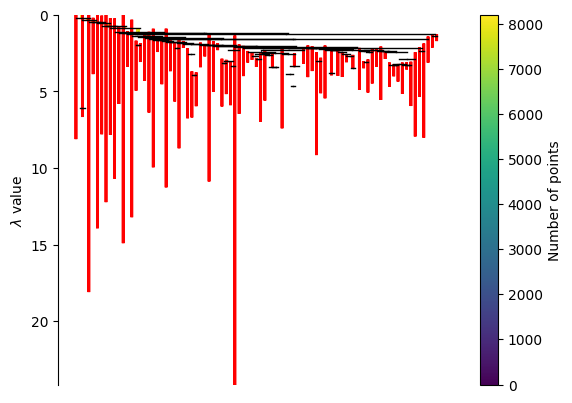

In [49]:
loaded_clusterer.condensed_tree_.plot(
    select_clusters=True, selection_palette=sns.color_palette()
)

In [50]:
# third, perform dimensionality reduction from 15 to 2

f_name = os.path.join(args.cache_folder, "reducer_umap_2.pkl")
print(f_name, "\n")

if not args.inference:
    reducer_2 = umap.UMAP(n_components=2)
    reducer_2.fit(embeddings_umap_dim_15)
    embeddings_umap_dim_2 = reducer_2.transform(embeddings_umap_dim_15)

    # Verify that the result of calling transform is
    # idenitical to accessing the embedding_ attribute
    assert np.all(embeddings_umap_dim_2 == reducer_2.embedding_)

    # cache fitted umap object
    pickle.dump(reducer_2, open(f_name, "wb"))

loaded_reducer_2 = pickle.load((open(f_name, "rb")))

embeddings_umap_dim_2 = loaded_reducer_2.transform(embeddings_umap_dim_15)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert np.all(embeddings_umap_dim_2 == loaded_reducer_2.embedding_)
embeddings_umap_dim_2.shape

/content/drive/MyDrive/colab_files/text_clustering/experiments/03_09_2023_22_34_08/reducer_umap_2.pkl 



(8192, 2)

In [51]:
ds["x"] = embeddings_umap_dim_2[:, 0]
ds["y"] = embeddings_umap_dim_2[:, 1]

In [52]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=ds["x"][ds["cluster"] != -1],
        y=ds["y"][ds["cluster"] != -1],
        mode="markers",
        marker_color=ds["cluster"][ds["cluster"] != -1],
        marker_colorscale="Viridis",
        text=ds["cluster"][ds["cluster"] != -1],
    )
)

fig.update_traces(marker={"size": 11, "opacity": 0.45}, showlegend=False)
fig.update_coloraxes(showscale=False)
fig.update_layout(width=550 * 1.5, height=400 * 1.5)
fig.show()

## Exemplar Sub-Clustering

* See [soft clustering explanation](https://hdbscan.readthedocs.io/en/latest/soft_clustering_explanation.html) for supporting information

In [56]:
# function copied from:
# https://hdbscan.readthedocs.io/en/latest/soft_clustering_explanation.html#distance-based-membership


def exemplars(cluster_id, condensed_tree):
    raw_tree = condensed_tree._raw_tree
    # Just the cluster elements of the tree, excluding singleton points
    cluster_tree = raw_tree[raw_tree["child_size"] > 1]
    # Get the leaf cluster nodes under the cluster we are considering
    leaves = hdbscan.plots._recurse_leaf_dfs(cluster_tree, cluster_id)
    # Now collect up the last remaining points of each leaf cluster (the heart of the leaf)
    result = np.array([])
    for leaf in leaves:
        max_lambda = raw_tree["lambda_val"][raw_tree["parent"] == leaf].max()
        points = raw_tree["child"][
            (raw_tree["parent"] == leaf) & (raw_tree["lambda_val"] == max_lambda)
        ]
        result = np.hstack((result, points))
    return result.astype(np.int)

In [ ]:
tree = loaded_clusterer.condensed_tree_

exemplar_ids = []
for i, c in enumerate(tree._select_clusters()):
    c_exemplars = exemplars(c, tree)
    print(f"Cluster {i} has {len(c_exemplars)} exemplars")
    exemplar_ids.extend(c_exemplars)

In [58]:
ds["exemplars yes/no"] = np.zeros(len(ds))
ds.loc[exemplar_ids, "exemplars yes/no"] = 1

assert len(ds[ds["exemplars yes/no"] == 1]) == len(exemplar_ids)

In [62]:
print("\n")
fig = go.Figure()

custom_scale = [
    "#949494",  # Gray
    "#F65314",  # Google Red
    "#4285F4",  # Google Blue
]

fig.add_trace(
    go.Scatter(
        x=ds["x"][ds["exemplars yes/no"] == 0],
        y=ds["y"][ds["exemplars yes/no"] == 0],
        mode="markers",
        marker_color=custom_scale[0],
        text=ds["cluster"][ds["exemplars yes/no"] == 0],
    )
)

fig.add_trace(
    go.Scatter(
        x=ds["x"][ds["exemplars yes/no"] == 1],
        y=ds["y"][ds["exemplars yes/no"] == 1],
        mode="markers",
        marker_color=ds["cluster"][ds["exemplars yes/no"] == 1],
        marker_colorscale="Viridis",
        text=ds["cluster"][ds["exemplars yes/no"] == 1],
    )
)

fig.update_traces(marker={"size": 11, "opacity": 0.45}, showlegend=False)
fig.update_coloraxes(showscale=False)
fig.update_layout(width=550 * 1.5, height=400 * 1.5)
fig.show()

In [63]:
len(ds.loc[exemplar_ids])

1294

In [64]:
embeddings_umap_dim_15[exemplar_ids].shape

(1294, 15)

In [ ]:
# fourth, perform exemplar sub-clustering

f_name = os.path.join(args.cache_folder, "clusterer_subs_hdbscan.pkl")
print(f_name, "\n")

if not args.inference:
    sub_clusterer = hdbscan.HDBSCAN(min_cluster_size=4, gen_min_span_tree=True)
    sub_clusterer.fit(embeddings_umap_dim_15[exemplar_ids])
    pickle.dump(sub_clusterer, open(f_name, "wb"))

loaded_sub_clusterer = pickle.load((open(f_name, "rb")))

if not args.inference:
    print(
        pd.DataFrame.equals(
            pd.Series(sub_clusterer.labels_).value_counts(),
            pd.Series(loaded_sub_clusterer.labels_).value_counts(),
        )
    )
    print(
        pd.DataFrame.equals(
            pd.Series(sub_clusterer.probabilities_).value_counts(),
            pd.Series(loaded_sub_clusterer.probabilities_).value_counts(),
        )
    )

print("\nCluster value counts:\n")
pd.Series(loaded_sub_clusterer.labels_).value_counts()

In [66]:
loaded_sub_clusterer.labels_

array([ 0,  0,  0, ..., 82, 82, 82])

In [69]:
ds["exemplar sub-cluster"] = np.repeat(np.nan, len(ds))
ds["cluster XX.YY"] = np.repeat(np.nan, len(ds))
# ds.loc[exemplar_ids] = loaded_sub_clusterer.labels_
ds
for i in range(len(ds.loc[exemplar_ids])):
    row = ds.loc[exemplar_ids].iloc[i]
    ds.loc[row.id, "exemplar sub-cluster"] = loaded_sub_clusterer.labels_[i]
for i in range(len(ds.loc[exemplar_ids])):
    row = ds.loc[exemplar_ids].iloc[i]
    ds.loc[row.id, "cluster XX.YY"] = (
        "Cluster "
        + str(row.cluster)
        + ", Sub-Cluster "
        + str(int(row["exemplar sub-cluster"]))
    )

# ds.loc[exemplar_ids]
# ds

<ipython-input-69-587ccd6b85dd>:10: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Cluster 0, Sub-Cluster 0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



In [70]:
ds_inner_exemplars = ds[ds["exemplars yes/no"] == 1]
ds_inner_exemplars = ds_inner_exemplars[
    ds_inner_exemplars["exemplar sub-cluster"] != -1
]
len(ds_inner_exemplars)

1292

In [72]:
print("\n")

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=ds["x"][ds["exemplars yes/no"] == 0],
        y=ds["y"][ds["exemplars yes/no"] == 0],
        mode="markers",
        marker_color=custom_scale[0],
        text=ds["cluster XX.YY"][ds["exemplars yes/no"] == 0],
    )
)

fig.add_trace(
    go.Scatter(
        x=ds_inner_exemplars["x"],
        y=ds_inner_exemplars["y"],
        mode="markers",
        marker_color=ds_inner_exemplars["exemplar sub-cluster"],
        marker_colorscale="Viridis",
        text=ds_inner_exemplars["cluster XX.YY"],
    )
)

fig.update_traces(marker={"size": 11, "opacity": 0.55}, showlegend=False)
fig.update_coloraxes(showscale=False)
fig.update_layout(width=550 * 1.5, height=400 * 1.5)
fig.show()

In [73]:
exemplar_coordinates = []
for i in range(len(ds_inner_exemplars)):
    row = ds_inner_exemplars.iloc[i]
    if row["exemplar sub-cluster"] != -1:
        exemplar_coordinates.append([row.x, row.y])

exemplar_coordinates = np.array(exemplar_coordinates)
exemplar_coordinates.shape

(1292, 2)

## Create summary themes knowledge graph

In [74]:
openai.api_key = os.getenv("OPENAI_API_KEY")
# openai.Model.list()

In [94]:
gpt_prompt = "Please identify the core theme per Sub-Cluster for the given prompts. Respond with an overall summary. Each summary cannot be longer than 1 sentence, but please be detailed in your responses. Let's think step by step before responding."

summaries = []

for sub_clust in np.unique(np.array(ds[ds["exemplars yes/no"] == 1]["cluster XX.YY"])):
    # gpt_prompt = "Please identify the core theme among the given prompts. The response cannot be longer than 1 sentence."

    sub_df = ds[ds["cluster XX.YY"] == sub_clust]
    if sub_df["cluster"].iloc[0] == 58:
        sub_prompts = sub_df["Prompt"].astype(str)
        sub_prompts = sub_prompts.reset_index(drop=True)

        # sub_prompts = "Task: " + sub_df["act"].astype(str) + ". Prompt: " + sub_df["prompt"].astype(str)

        # sub_clust = sub_clust.split(", ")[-1]
        gpt_prompt += "\n" + sub_clust + ": "
        gpt_prompt += f"\n" + str(sub_prompts) + '"\n'


print(gpt_prompt)

Please identify the core theme per Sub-Cluster for the given prompts. Respond with an overall summary. Each summary cannot be longer than 1 sentence, but please be detailed in your responses. Let's think step by step before responding.
Cluster 58, Sub-Cluster 68: 
0     a beautiful cyborg girl, fantasy, portrait, sh...
1     hyperrealistic photography of a stunningly bea...
2     hyperrealistic photography of a stunningly bea...
3     A professional portrait of a young cyborg woma...
4     cyborg girl with fangs, purple and pink hair, ...
5     Ultra realistic cyborg extreme beautiful woman...
6     ultra realistic, beautiful cyborg woman, sci-f...
7     portrait of agatha vega as a cyberpunk cyborg....
8     ultra realistic, beautiful cyborg woman, sci-f...
9     Panorama screenshot beautiful female cyborg, b...
10    young asian woman, iris van herpen, perfect sy...
11    ultra realistic, beautiful female cyborg in a ...
12    evil faceless cyborg android queen, ultra real...
13    C

In [95]:
MODEL = "gpt-3.5-turbo-16k"
full_dict_response = openai.ChatCompletion.create(
    model=MODEL,
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": gpt_prompt},
    ],
    temperature=0,
)

text_generation = full_dict_response["choices"][0]["message"]["content"]

print(text_generation)

Cluster 58, Sub-Cluster 68: The core theme of this sub-cluster is the portrayal of beautiful cyborg women in a fantasy or sci-fi setting.

Cluster 58, Sub-Cluster 69: The core theme of this sub-cluster is hyperrealistic portraits of cyberpunk characters, mainly focusing on teenagers or men.

Cluster 58, Sub-Cluster 72: The core theme of this sub-cluster is the depiction of robots and mechanical beings in various scenarios, such as battles, construction, or as artistic concepts.

Cluster 58, Sub-Cluster 73: The core theme of this sub-cluster is the representation of organic cyborgs, combining elements of nature and technology, often with a fantasy or surrealistic touch.


In [96]:
individual_respones = text_generation.split("\n")
individual_respones_formatted = []
for i in individual_respones:
    if len(i) > 0:
        individual_respones_formatted.append(i)

individual_respones_formatted

['Cluster 58, Sub-Cluster 68: The core theme of this sub-cluster is the portrayal of beautiful cyborg women in a fantasy or sci-fi setting.',
 'Cluster 58, Sub-Cluster 69: The core theme of this sub-cluster is hyperrealistic portraits of cyberpunk characters, mainly focusing on teenagers or men.',
 'Cluster 58, Sub-Cluster 72: The core theme of this sub-cluster is the depiction of robots and mechanical beings in various scenarios, such as battles, construction, or as artistic concepts.',
 'Cluster 58, Sub-Cluster 73: The core theme of this sub-cluster is the representation of organic cyborgs, combining elements of nature and technology, often with a fantasy or surrealistic touch.']

In [97]:
summaries_dict = {}

for item in individual_respones_formatted:
    content = item.split(": ")[-1]
    sub_clust = item.split(":")[0]
    summaries_dict[sub_clust] = content
summaries_dict

{'Cluster 58, Sub-Cluster 68': 'The core theme of this sub-cluster is the portrayal of beautiful cyborg women in a fantasy or sci-fi setting.',
 'Cluster 58, Sub-Cluster 69': 'The core theme of this sub-cluster is hyperrealistic portraits of cyberpunk characters, mainly focusing on teenagers or men.',
 'Cluster 58, Sub-Cluster 72': 'The core theme of this sub-cluster is the depiction of robots and mechanical beings in various scenarios, such as battles, construction, or as artistic concepts.',
 'Cluster 58, Sub-Cluster 73': 'The core theme of this sub-cluster is the representation of organic cyborgs, combining elements of nature and technology, often with a fantasy or surrealistic touch.'}

In [98]:
# for i in range(len(ds)):
# row = ds.iloc[i]
# ds.loc[row.id, "theme"] = summaries_dict[row["cluster XX.YY"]]
# ds

## Write final df results to disk

In [100]:
# write final ds to disk
f_name = os.path.join(
    args.cache_folder, "stable_diffusion_prompts_dataframe_cached_with_results.xlsx"
)
print(f_name, "\n")

# re-order cols
ds = ds[
    [
        "id",
        "cluster",
        "x",
        "y",
        "cluster membership prob",
        "exemplars yes/no",
        "exemplar sub-cluster",
        "cluster XX.YY",
        # "theme",
        "Prompt",
    ]
]

# write with adjusted col width
if not args.inference:
    with pd.ExcelWriter(f_name) as writer:
        ds.to_excel(writer, sheet_name="All Prompts")
        auto_adjust_xlsx_column_width(ds, writer, sheet_name="All Prompts", margin=1)

/content/drive/MyDrive/colab_files/text_clustering/experiments/03_09_2023_22_34_08/stable_diffusion_prompts_dataframe_cached_with_results.xlsx 



## Format a JSON viz graph

In [102]:
# optional ds cached loading
ds = pd.read_excel(
    os.path.join(
        args.cache_folder, "stable_diffusion_prompts_dataframe_cached_with_results.xlsx"
    ),
    index_col="Unnamed: 0",
)
ds

,id,cluster,x,y,cluster membership prob,exemplars yes/no,exemplar sub-cluster,cluster XX.YY,Prompt
0,0,46,-0.680549,3.641108,1.000000,1,46.0,"Cluster 46, Sub-Cluster 46","young, curly haired, redhead Natalie Portman ..."
1,1,51,3.632030,-6.115438,0.954661,0,NaN,NaN,a mystical tribal goddess adorned with feather...
2,2,58,0.456526,10.792448,0.790786,0,NaN,NaN,"molly millions, portrait of a beautiful cyberp..."
3,3,58,-1.573194,12.297340,1.000000,0,NaN,NaN,"cyborg sweating water, big drops of sweat, for..."
4,4,-1,3.650549,3.858677,0.000000,0,NaN,NaN,"Max Headroom in a Perfume advertisement, magic..."
...,...,...,...,...,...,...,...,...,...
8187,8187,-1,5.203712,-1.365138,0.000000,0,NaN,NaN,"portrait of samuel jackson as gandalf, by alan..."
8188,8188,-1,11.489166,-0.312350,0.000000,0,NaN,NaN,a photorealistic hyperrealistic render of an i...
8189,8189,-1,6.197484,-4.391610,0.000000,0,NaN,NaN,"occult leader by artgerm, tooth wu, dan mumfor..."
8190,8190,60,-0.643137,-7.476315,0.895878,0,NaN,NaN,"front shot of an alien cargo ship, intricate, ..."
